Networks with Multiple Layers
=============================



## Overview



Here we will use  the **MNIST fashion** data set for classification, available here
[https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)
or using `torchvision.datasets.FashionMNIST`.

We will also monitor our model with the help of Tensorboard.

We will start from a Softmax Regression which we construct from scratch.
This is them refactored to use the standard modules from `pytorch`, e.g.,

-   `torch.nn.Module`, `torch.nn.Linear`, &#x2026;
-   `torch.optim` for optimization
-   `DataLoader`

Finally you have to construct and train a MLP.



## Imports



The *standard* imports:



In [1]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision

## Tensorboard



For the following, you have to install **Tensorboard**. First you need to install it with

    pip install tensorboard

You have to run it from the command line with

    tensorboard --log_dir <DIR>

Later your models will write logging information to the directory `DIR`.
For now it is assumed that

    DIR=$HOME/tmp/tensorboard

Tensorboard can be accessed under [http://localhost:6006](http://localhost:6006).

You will find more information here:
[https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html)



In [2]:
!pip install tensorboard

In [3]:
!tensorboard --log_dir .

TensorFlow installation not found - running with reduced feature set.
Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.


## Data



### FashionMNIST



Some info from [https://pytorch.org/docs/stable/torchvision/datasets.html](https://pytorch.org/docs/stable/torchvision/datasets.html)
> TORCHVISION.DATASETS
> All datasets are subclasses of `torch.utils.data.Dataset` i.e, they have `__getitem__` and `__len__` methods implemented.
> Hence, they can all be passed to a `torch.utils.data.DataLoader` which can load multiple samples
> parallelly using `torch.multiprocessing` workers.Here is the data set we want to use:



In [4]:
from torchvision.datasets import FashionMNIST
# if you want, read the doc string:
?FashionMNIST

Init signature:
FashionMNIST(
    root: str,
    train: bool = True,
    transform: Optional[Callable] = None,
    target_transform: Optional[Callable] = None,
    download: bool = False,
) -> None
Docstring:     
`Fashion-MNIST <https://github.com/zalandoresearch/fashion-mnist>`_ Dataset.

Args:
    root (string): Root directory of dataset where ``FashionMNIST/raw/train-images-idx3-ubyte``
        and  ``FashionMNIST/raw/t10k-images-idx3-ubyte`` exist.
    train (bool, optional): If True, creates dataset from ``train-images-idx3-ubyte``,
        otherwise from ``t10k-images-idx3-ubyte``.
    download (bool, optional): If True, downloads the dataset from the internet and
        puts it in root directory. If dataset is already downloaded, it is not
        downloaded again.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.RandomCrop``
    target_transform (callable, optional): A function/tr

In [5]:
from torchvision import transforms
transform = transforms.Compose([transforms.ToTensor()])

fashion_train = FashionMNIST("~/no_backup/data_fashion/",
               train=True, # the default
               download=True,
               transform=transform
)

# this will will not be useed in to following
fashion_test = FashionMNIST("~/no_backup/data_fashion/",
               train=False,
               download=True,
               transform=transform # converts to [0,1]
)
# if you like you can later evaluate your final model with it

Let us look at the data. Here are the classes:



In [6]:
fashion_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
print ("Type", type(fashion_train.data))
print ("dtype", fashion_train.data.dtype)
print ("Shape", fashion_train.data.shape)
print ("targets", fashion_train.targets.shape)

Type <class 'torch.Tensor'>
dtype torch.uint8
Shape torch.Size([60000, 28, 28])
targets torch.Size([60000])


So a big tensor, each picture is a 28x28 pixel picture.
But also note the `dtype` is a `torch.uint`.



In [8]:
fashion_train.data.float().dtype

torch.float32

Lets us show some examples, together with their labels:



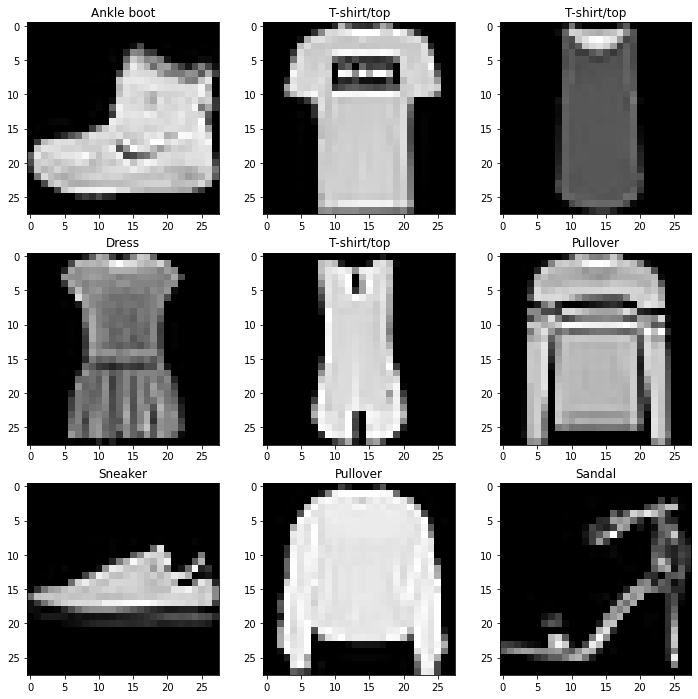

In [9]:
fig, axs = plt.subplots(3,3, figsize=(12,12))
axs = axs.flatten()
for i, ax in zip(range(len(axs)), axs):
    ax.imshow(fashion_train.data[i], cmap='gray')
    ax.set_title(fashion_train.classes[fashion_train.targets[i]])

### Data Loaders



The data can be passed in a model with a `DataLoader`, like shown below.



In [10]:
from torch.utils.data import DataLoader
train_dl = DataLoader(fashion_train, batch_size=10, shuffle=True)

print('Number of data points', len(fashion_train))
print ('Number of batches', len(train_dl))

for X, y in train_dl:
    print (X.shape)
    print(y.shape)
    break

Number of data points 60000
Number of batches 6000
torch.Size([10, 1, 28, 28])
torch.Size([10])


## Start from Softmax Regression



### Introduction



We will understand this as a classification problem with $28*28$ features and first apply Softmax regresssion.
Internally we need to  reshape the data. At the end we expect a $N\times 784$ tensor,
where $N$ is the number of examples in the batch.
We see that `X` is of shape $N \times d \times d$, with $d=28$.
To flatten it (using the batch from the previous section) use for example



In [11]:
X.flatten(start_dim=1).shape

torch.Size([10, 784])

We start from  our solution from last time:



In [12]:
def softmax_old(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition

def cross_entropy_old(y_hat, y):
    return (-torch.log(y_hat[range(len(y_hat)), y])).mean()

class SoftmaxNetwork_old:

    def __init__(self, num_input, num_output, dtype=torch.float64):
        """
        Args:
            num_input: dimension of input space
            num_output: number if output classes
        """
        self.w = torch.randn((num_input,num_output),
                             dtype=dtype).requires_grad_(True)
        self.b = torch.randn(num_output, dtype=dtype).requires_grad_(True)

    def forward(self, X):
        """
        Args:
            X: tensor of shape (n, d)
        """
        y = (X @ self.w + self.b)
        return softmax_old(y)

### Refactor: Softmax and Cross-Entropy



Basically an equivalent implementation of `Softmax` using PyTorch  functions is shown here:



In [13]:
import  torch.nn as nn

softmax = nn.Softmax(dim=1)

def test_softmax():
    X = torch.normal(0,1, size=(4,2))
    # would throw an exception if assertion is wrong
    np.testing.assert_almost_equal(
       softmax(X).numpy(), softmax_old(X) )

test_softmax()

But due to numerical reasons it is recommended to use `LogSoftmax`:



In [14]:
log_softmax = nn.LogSoftmax(dim=1)

def test_softmax2():
    X = torch.normal(0,1, size=(4,2))
    # would throw an exception if assertion is wrong
    np.testing.assert_almost_equal(
       softmax(X).numpy(), np.exp(log_softmax(X)))

test_softmax2()

Of course, now we have to change our loss function, which now works on the logarithm of the softmac:



In [15]:
# test it
def test_cross_entropy():
    loss_func_old =cross_entropy_old

    loss_func = nn.NLLLoss()

    X = torch.normal(0,1, size=(4,2))
    y = torch.tensor([1,0,1,1])

    np.testing.assert_almost_equal(
        loss_func(log_softmax(X), y).numpy(),
        loss_func_old(softmax_old(X), y).numpy()
    )


test_cross_entropy()

A second (equivalent method) is to use the `CrossEntropyLoss`:



In [16]:
def test_cross_entropy2():
    loss_func = nn.NLLLoss()
    loss_func_new = nn.CrossEntropyLoss()

    # test it
    X = torch.normal(0,1, size=(4,2))
    y = torch.tensor([1,0,1,1])

    # throws an exception if the assertion fails
    np.testing.assert_almost_equal(
        loss_func_new(X, y).numpy(),
        loss_func(log_softmax(X), y).numpy())

test_cross_entropy2()

In this case the network has to return the result of the  output
layer without the softmax!

Here is our new network:



In [17]:
class SoftmaxNetwork:
    def __init__(self):
        num_input=28*28
        num_output=10
        self.w = torch.randn((num_input,num_output),
                             dtype=torch.float32).requires_grad_(True)
        self.b = torch.randn(num_output, dtype=torch.float32).requires_grad_(True)

    # New method: call operator
    def __call__(self, X):
        return self.forward(X)

    def forward(self, X):
        """
        Args:
            X: tensor of shape (n, d, d)
        """
        # flatten X!
        y = (X.flatten(start_dim=1) @ self.w + self.b)
        return log_softmax(y)

### Refactor: Inherit from nn.Module



Usually, PyTorch models inherit from `torch.nn.module`.
`torch.nn` contains many useful modules and layers.
For  example an simple **linear layer**, also
called **fully connected layer**, is provided by `nn.Linear`.
Also flattening can be done with `nn.Flatten`,
which can be viewed as a special layer.

Using these new modules, we obtain the following class



In [18]:
class LinearNetwork(nn.Module):
    def __init__(self, num_input=28*28, num_output=10):
        # call constructor of super class
        super().__init__()

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_input, num_output)

    def forward(self, X):
        """
        Args:
            X: tensor of shape (n, d, d)
        """
        X = self.flatten(X)
        return self.fc(X)
        # softmax is now computed in the loss function

Let us see the network in action. It inherits  a `__call__()` operator,
which in turn calls the forward function (see below).



In [19]:
model = LinearNetwork()

# a random image
X = torch.normal(0,1, size=(1, 28*28))
print("unnormalize probabilities :\n", model.forward(X))

np.testing.assert_almost_equal(
    model.forward(X).detach().numpy(),
    model(X).detach().numpy())

unnormalize probabilities :
 tensor([[ 0.0995,  0.4096,  0.3288,  0.5757,  0.3280,  0.6182, -0.4100,  0.3981,
          1.2380,  0.4611]], grad_fn=<AddmmBackward0>)


The parameters can be accessed using the `parameters()` method
of the model object



In [20]:
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([10, 784])
Parameter containing:
tensor([[-0.0249, -0.0343, -0.0100,  ..., -0.0357, -0.0337, -0.0144],
        [-0.0087,  0.0311,  0.0203,  ..., -0.0010,  0.0257, -0.0218],
        [-0.0165,  0.0267,  0.0135,  ..., -0.0085, -0.0351,  0.0020],
        ...,
        [-0.0229, -0.0257,  0.0251,  ...,  0.0329, -0.0171,  0.0076],
        [ 0.0185,  0.0039, -0.0028,  ..., -0.0240, -0.0328,  0.0031],
        [-0.0189,  0.0220, -0.0267,  ..., -0.0046, -0.0044,  0.0169]],
       requires_grad=True)
torch.Size([10])
Parameter containing:
tensor([-0.0018, -0.0042,  0.0064, -0.0131, -0.0198, -0.0182, -0.0340,  0.0338,
        -0.0078, -0.0132], requires_grad=True)


In [21]:
for name, p in model.named_parameters():
    print(name)
    print(p)

fc.weight
Parameter containing:
tensor([[-0.0249, -0.0343, -0.0100,  ..., -0.0357, -0.0337, -0.0144],
        [-0.0087,  0.0311,  0.0203,  ..., -0.0010,  0.0257, -0.0218],
        [-0.0165,  0.0267,  0.0135,  ..., -0.0085, -0.0351,  0.0020],
        ...,
        [-0.0229, -0.0257,  0.0251,  ...,  0.0329, -0.0171,  0.0076],
        [ 0.0185,  0.0039, -0.0028,  ..., -0.0240, -0.0328,  0.0031],
        [-0.0189,  0.0220, -0.0267,  ..., -0.0046, -0.0044,  0.0169]],
       requires_grad=True)
fc.bias
Parameter containing:
tensor([-0.0018, -0.0042,  0.0064, -0.0131, -0.0198, -0.0182, -0.0340,  0.0338,
        -0.0078, -0.0132], requires_grad=True)


This allows a standard way to optimize the parameters, for example:



In [35]:
# a batch of three random pictures
loss_func = nn.CrossEntropyLoss()
model = LinearNetwork(num_input=28*28, num_output=3)

X = torch.normal(0,1, size=(3, 28*28))
y = torch.tensor([1,0,2])

loss = loss_func(model(X), y)
loss.backward()

lr = 1.0

print('before: fc.bias', model.get_parameter('fc.bias'))

with torch.no_grad():
    for name, p in model.named_parameters():
        p -= lr*p.grad # an inplace operation
model.zero_grad()

print('after: fc.bias', model.get_parameter('fc.bias'))

before: fc.bias Parameter containing:
tensor([ 0.0226, -0.0270,  0.0282], requires_grad=True)
after: fc.bias Parameter containing:
tensor([-0.0247,  0.0167,  0.0318], requires_grad=True)


The parameter update can be delegated to the `optim` package of PyTorch.
An example is shown here:



In [23]:
import torch.optim as optim

X = torch.normal(0,1, size=(3, 4*4))
y = torch.tensor([0, 1, 2])

model = LinearNetwork(num_input=16, num_output=3)

opt = optim.SGD(model.parameters(), lr=lr)

for _ in range(3):
    loss = loss_func(model(X), y)
    loss.backward()
    opt.step()
    model.zero_grad()

y_hat = model(X)

print("Unnormalized probs \n", y_hat)
print()
print("Prediction",y_hat.argmax(dim=1))

Unnormalized probs 
 tensor([[ 4.7978, -3.7943, -0.1170],
        [-1.9904,  4.4749, -1.4318],
        [-0.6246, -3.6907,  3.3198]], grad_fn=<AddmmBackward0>)

Prediction tensor([0, 1, 2])


### Implement other metrics



Often we are interested in the so called accuracy:



In [24]:
def accuracy(preds, truth):
    return (truth == preds).float().mean()

X = torch.normal(0,1, size=(3, 4*4))
y = torch.tensor([0, 1, 2])

model = LinearNetwork(num_input=16, num_output=3)

opt = optim.SGD(model.parameters(), lr=lr)

for _ in range(2):
    loss = loss_func(model(X), y)
    loss.backward()
    opt.step()
    model.zero_grad()
    with torch.no_grad():
        acc = accuracy(model(X).argmax(dim=1), y )
        print(f"acc={acc}")

acc=1.0
acc=1.0


Instead of our own implementation
we use the `torchmetrics` package (it provides some additional features, like aggregation over batches, see code below).
Install it with

    pip install torchmetrics

Example for global aggregation:



In [25]:
!pip install torchmetrics

In [26]:
from torchmetrics import Accuracy

metric = Accuracy()
y = torch.tensor([0, 1, 2])
p1 = torch.tensor([0, 1, 2])
p2 = torch.tensor([1, 0, 0])

print("batch #1", metric(y, p1))
print("batch #2", metric(y, p2))
print("global", metric.compute())
metric.reset()

batch #1 tensor(1.)
batch #2 tensor(0.)
global tensor(0.5000)


### Training Loop



Lets train it with SGD but using the data loader. Also we split the training
data into a validation set and one real training data set.
We r want to record the accuracy on the validation set and use Tensorboard for monitoring.
Here is a helper function to set the path of Tensorboard.
Adapt it to your own needs.



In [27]:
import os.path
import datetime
from pathlib import Path

def get_path(prefix='', name='', log_dir='tmp/tensorboard'):
    if len(name)==0:
        name = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    return os.path.join(Path.home(), log_dir, prefix, name)

print(get_path(prefix='advdm_mlp'))
print(get_path(prefix='advdm_mlp', name='exp1'))

C:\Users\steffen.lang\tmp/tensorboard\advdm_mlp\2022-11-09_13-30-03
C:\Users\steffen.lang\tmp/tensorboard\advdm_mlp\exp1


OK, so let us start.
This could take a while, you can lower the number of epochs to speed it up.



In [28]:
from torch.utils.tensorboard import SummaryWriter

lr=0.05
batch_size = 256 #64

n_epochs = 20
N_train = 50000
N_valid = 10000

# Workarournd to speed up the data loader?
from torch.utils.data import TensorDataset

if not isinstance(fashion_train, TensorDataset):
    fashion_train =  TensorDataset(fashion_train.data.float()/255.0, fashion_train.targets)

train_ds, valid_ds = torch.utils.data.random_split(fashion_train, [N_train, N_valid])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

print('Number of training data points', N_train)
print('Number of training batches', len(train_dl))
print('Number of validation data points', N_valid)
print('Number of validation batches', len(valid_dl))

writer = SummaryWriter(get_path('advdm_mlp'))
#writer.add_text('Model', 'Linear model')

model = LinearNetwork()
opt = optim.SGD(model.parameters(), lr=lr)

loss_func = nn.CrossEntropyLoss()

start = time.time()
loss_train = 0
loss_val = 0
acc_val = 0

metric = Accuracy()

for epoch in range(n_epochs):
    running_loss = 0.0
    for X, y in train_dl:
        model.zero_grad()
        loss = loss_func(model(X), y)
        loss.backward()
        opt.step()
        running_loss += loss.item()*X.shape[0]

    loss_train = running_loss/N_train
    writer.add_scalar("Loss/train", loss_train, epoch)

    with torch.no_grad():
        loss_val=0
        for X, y in valid_dl:
            N = X.shape[0]
            y_pred = model(X)
            metric(y_pred, y)
            loss_val += loss_func(model(X), y).item()*N

    loss_val /= N_valid
    acc_val =  metric.compute()
    metric.reset()

    writer.add_scalar("Loss/val", loss_val, epoch)
    writer.add_scalar("Accuracy/val", acc_val, epoch)
    writer.flush()

writer.add_hparams(
    {'lr': lr, 'batch_size': batch_size, 'h_layers': 0},
    {'hparam/loss_val': loss_val,
     'hparam/loss_train': loss_train,
     'hparam/acc_val': acc_val
     })

writer.flush()
writer.close()

print(f'eplapsed time {time.time() - start:2.2f} sec')
print(f'loss train {loss_train:.2f}')
print(f'loss validation {loss_val:.2f}')

Number of training data points 50000
Number of training batches 196
Number of validation data points 10000
Number of validation batches 20
eplapsed time 13.52 sec
loss train 0.45
loss validation 0.46


## Task: Build an MLP



So far we used a simple linear network for classification.
You should now add a hidden layer with 256 nodes and train and evaluate it.



In [36]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, num_input=28*28, num_hidden=256, num_output=10):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(num_input, num_hidden)
        self.fc2 = nn.Linear(num_hidden, num_output)   

    def forward(self, X):
        """
        Args:
            X: tensor of shape (n, d)
        """
        return self.fc2(F.relu(self.fc1(self.flatten(X))))

    # softmax is now computed in the loss function

In [37]:
from torch.utils.tensorboard import SummaryWriter

lr=0.05
batch_size = 256 #64

n_epochs = 20
N_train = 50000
N_valid = 10000

# Workarournd to speed up the data loader?
from torch.utils.data import TensorDataset

if not isinstance(fashion_train, TensorDataset):
    fashion_train =  TensorDataset(fashion_train.data.float()/255.0, fashion_train.targets)

train_ds, valid_ds = torch.utils.data.random_split(fashion_train, [N_train, N_valid])
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

print('Number of training data points', N_train)
print('Number of training batches', len(train_dl))
print('Number of validation data points', N_valid)
print('Number of validation batches', len(valid_dl))

writer = SummaryWriter(get_path('advdm_mlp'))
#writer.add_text('Model', 'Linear model')

model = MLP()
opt = optim.SGD(model.parameters(), lr=lr)

loss_func = nn.CrossEntropyLoss()

start = time.time()
loss_train = 0
loss_val = 0
acc_val = 0

metric = Accuracy()

for epoch in range(n_epochs):
    running_loss = 0.0
    for X, y in train_dl:
        model.zero_grad()
        loss = loss_func(model(X), y)
        loss.backward()
        opt.step()
        running_loss += loss.item()*X.shape[0]

    loss_train = running_loss/N_train
    writer.add_scalar("Loss/train", loss_train, epoch)

    with torch.no_grad():
        loss_val=0
        for X, y in valid_dl:
            N = X.shape[0]
            y_pred = model(X)
            metric(y_pred, y)
            loss_val += loss_func(model(X), y).item()*N

    loss_val /= N_valid
    acc_val =  metric.compute()
    metric.reset()

    writer.add_scalar("Loss/val", loss_val, epoch)
    writer.add_scalar("Accuracy/val", acc_val, epoch)
    writer.flush()

writer.add_hparams(
    {'lr': lr, 'batch_size': batch_size, 'h_layers': 0},
    {'hparam/loss_val': loss_val,
     'hparam/loss_train': loss_train,
     'hparam/acc_val': acc_val
     })

writer.flush()
writer.close()

print(f'eplapsed time {time.time() - start:2.2f} sec')
print(f'loss train {loss_train:.2f}')
print(f'loss validation {loss_val:.2f}')

Number of training data points 50000
Number of training batches 196
Number of validation data points 10000
Number of validation batches 20
eplapsed time 21.14 sec
loss train 0.38
loss validation 0.45
